# Import des Netzwerks für das Modell

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
import random

import pypsa

%matplotlib inline

## Setup

Setting up all the network's main components

All of the data is taken from another thesis, written at the same chair at TU Berlin as this one. The data is provided in the form of excel-files and is read using pandas methods.

### Variables

In [2]:
nw = pypsa.Network()

In [3]:
nw.set_snapshots([p for p in range(5)])

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

Setting the paths for the data

In [5]:
ex1 = pd.ExcelFile(cur_path + "map_cities.xlsx")
ex2 = pd.ExcelFile(cur_path + "map_countries.xlsx")

all_gens = pd.read_excel(cur_path + "Kraftwerksliste_ÜNB_Entwurf_Szenariorahmen_2030_V2019.xlsx")

### Setup within Germany

In [6]:
df_buses = pd.read_excel(ex1, sheet_name="buses", header=0, usecols="B:D")
df_lines = pd.read_excel(ex1, sheet_name="lines", header=0, usecols="B:D")

### Setup abroad

In [7]:
df_countries = pd.read_excel(ex2, sheet_name="buses", header=0, usecols="B:D")
df_countries_lines = pd.read_excel(ex2, sheet_name="lines", header=0, usecols="B:D")
df_buses = df_buses.append(df_countries).reset_index(drop=True)
df_lines = df_lines.append(df_countries_lines).reset_index(drop=True)

Calculating the length of each line by Pythagoras.
The factor enables converting the distance in lattitude/longitude to kilometers

In [8]:
df_lines["length"] = 0
df_lines["x"]=0.0001
df_lines["s_nom"]=2500
factor_coords_to_km = 111

for i in range(len(df_lines)):
    x_val = df_buses["x"][df_lines["bus0"][i]] - df_buses["x"][df_lines["bus1"][i]]
    y_val = df_buses["y"][df_lines["bus0"][i]] - df_buses["y"][df_lines["bus1"][i]]
    df_lines.at[i, "length"] = (math.sqrt(x_val**2 + y_val**2) * factor_coords_to_km)

In [9]:
pypsa.io.import_components_from_dataframe(nw, df_buses, "Bus")
pypsa.io.import_components_from_dataframe(nw, df_lines, "Line")

### Map topography

(<matplotlib.collections.PathCollection at 0x21a2625b0b8>,
 <matplotlib.collections.LineCollection at 0x21a2625b748>)

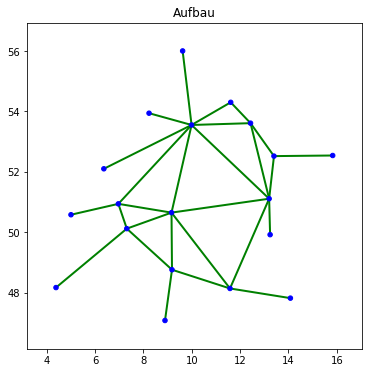

In [10]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(6,6)

nw.plot(bus_sizes=20, title="Aufbau")

### Generators

In [11]:
# only active generators
filtered = all_gens.loc[all_gens["Status 31.12.2016"]=="In Betrieb"]
# take the most powerful of each type of generator for each of the ÜNB
filtered = filtered.groupby([all_gens["Energieträger"], all_gens["ÜNB"]]).max()
# only 3 kinds of energysource
classic_gens = filtered[(filtered.Energieträger=="Braunkohle") | (filtered.Energieträger=="Steinkohle") | (filtered.Energieträger=="Erdgas")]
# get rid of multiple index columns
classic_gens.reset_index(drop=True, inplace=True)
# Vereinfachung der Indizes
classic_gens = classic_gens[["Betreiber", "Energieträger", "ÜNB", "Bundesland", "Nettoleistung 31.12.2016 [MW]"]].copy()

Add correct busnumber to each generator by comparing regions from df with buses

In [12]:
classic_gens["bus"] = 0

for j in range(len(classic_gens)):
    # find out index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(nw.buses.name) if classic_gens["Bundesland"][j] in s]
    classic_gens.at[j, "bus"] = indices[0]

In [13]:
classic_gens.rename(columns={"Betreiber":"name",
                             "Energieträger":"carrier",
                             "Nettoleistung 31.12.2016 [MW]":"p_nom"}, inplace=True)
classic_gens["committable"] = True

In [14]:
pypsa.io.import_components_from_dataframe(nw, classic_gens, "Generator")

Manually adding Germany's offshore windparks to the system, waiting for more data

In [15]:
nw.add("Generator", name="Offshore Nordsee",
       bus=17,
       carrier="wind",
       p_nom="300",
       committable=True)

nw.add("Generator", name="Offshore Ostsee",
       bus=18,
       carrier="wind",
       p_nom="500",
       committable=True)

### Temporary Loads for testing

In [16]:
nw.generators.p_nom.sum()

7792.0

In [17]:
for i in range(8):
    nw.add("Load", "myload{0}".format(i), bus=i, p_set=[random.randint(300, 900) for p in range(len(nw.snapshots))])

## Linear Optimal Power Flow (incl. unit commitment for generators)

In [18]:
nw.lopf(solver_name="gurobi")

INFO:pypsa.pf:Slack bus for sub-network 0 is 8
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x361
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 636
  Number of variables: 361
  Number of binary variables: 65
  Number of integer variables: 65
  Number of continuous variables: 296
  Number of nonzeros: 1211
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (s

('ok', 'optimal')

In [19]:
nw.generators_t.p["Offshore Nordsee"]

0    3.000000e+02
1    3.000000e+02
2    3.000000e+02
3    3.000000e+02
4   -4.547474e-13
Name: Offshore Nordsee, dtype: float64

## Visualization

In [20]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs

Line graph to display the dispatched amount of energy per plant

ValueError: When stacked is True, each column must be either all positive or negative.Offshore Nordsee contains both positive and negative values

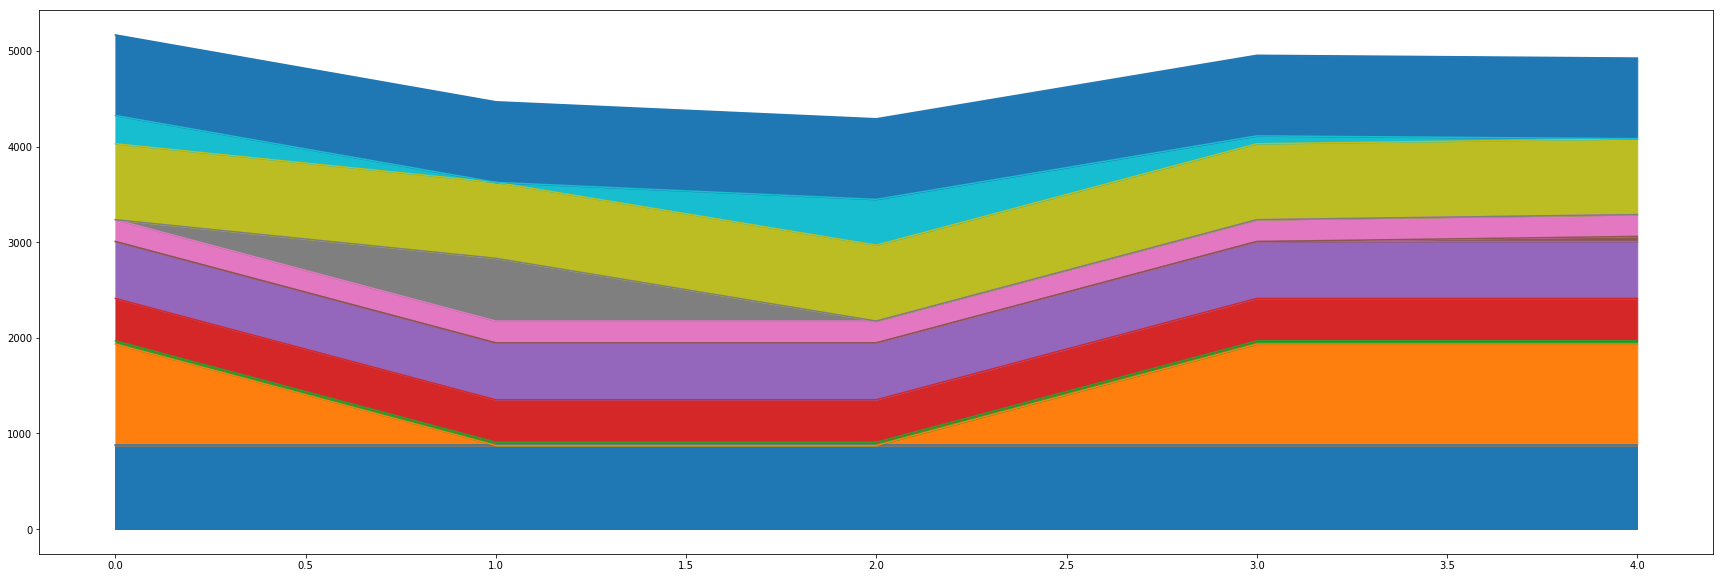

In [21]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(30,10)

(nw.generators_t.p).plot(kind="area",ax=ax, grid=True)

ax.set_xlabel("Snaps")
ax.set_ylabel("MW")